In [114]:
import numpy as np
import random
import matplotlib.pyplot as plt
import json

In [115]:
class User:

    def __init__(self, userId):
        self.ID = userId
        # self.movie_ratings = movie_ratings #doesn't work because it creates a reference to the same dictionary
        self.movie_ratings = {}
        self.added_movies = 0

    def add_movie_rating(self, movieId, rating):
        if not isinstance(movieId, int):
            raise TypeError("movieId must be an integer")
        if movieId in self.movie_ratings.keys():
            print(f"User {self.ID} already rated movie {movieId}")
            return
        self.added_movies += 1
        #print(f"User {self.ID} rated movie {movieId} with a rating of {rating}")
        self.movie_ratings[movieId] = rating

    def __hash__(self):
        return hash(self.ID)
    
    def __repr__(self):
        return f"User {self.ID} rated {len(self.movie_ratings)} movies"

class Movie:
    """ This class provides a way to store movie related information """
    
    def __init__(self, movieId, title, genres=[]):
        self.ID = movieId
        self.title = title
        self.genres = genres
    
    def __repr__(self):
        return f"Movie: {self.title} ({self.ID})"
    
    def __hash__(self):
        return hash(self.ID)

In [116]:
def read_movies(filename, nlines="all", verbose = 0) -> list[Movie]:
    """ Reads the movies from the file and returns a list of Movie objects, where indices are sequential,
     but movie ids are not.
    """
    movies = []
    ID = None
    title = None
    genres = []
    if nlines == "all":
        nlines = float("inf")
    with open(filename, "r",encoding="utf-8") as f:
        for line in f:
            # Skip the header
            if line.startswith("movieId"):
                continue
            if len(movies) >= nlines:
                break
            sp = line.strip().split(",")
            if len(sp) == 3:
                ID, title, genres = sp
            # If the title has comma, then it is in quotes and the split is incorrect
            elif len(sp) > 3:
                ID = sp[0]
                genres = sp[-1]
                title = get_title_from_movie_data(line)
            ID = int(ID)
            genres = genres.split("|")
            movie = Movie(ID, title, genres)
            movies.append(movie)
            if verbose > 0:
                print(movie)
    print(f"Read {len(movies)} movies from {filename}")
    return movies


def get_title_from_movie_data(line : str) -> str:
    """ Returns the title from the movie data line, if it is in quotes"""
    first_quote = line.find('"')
    last_quote = line.rfind('"')
    if first_quote == -1 or last_quote == -1:
        return line.split(",")[1]
    return line[first_quote+1:last_quote]


def read_ratings(filename, nlines = "all", verbose=0) -> list[User]:
    """ Reads the ratings from the file and returns a list of User objects,
    where indices are sequential, but user ids are not.
    """
    users = {}
    read_lines = 0
    if nlines == "all":
        nlines = float("inf")
    with open(filename, "r") as f:
        for line in f:
            # Skip the header
            if line.startswith("userId"):
                continue
            if read_lines >= nlines:
                break
            read_lines += 1
            # Split the line into the userId, movieId, rating, and timestamp
            userId, movieId, rating, timestamp = line.strip().split(",")
            userId = int(userId)
            movieId = int(movieId)
            rating = float(rating)
            # Create a User object if it doesn't exist
            if userId not in users.keys():
                if verbose > 0:
                    print(f"Creating user {userId}")
                users[userId] = User(userId)
            # Add the movie rating to the user
            users[userId].add_movie_rating(movieId, rating)
    print(f"Read {len(users)} users from {filename}")
    return list(users.values())

MOVIES = read_movies("./data/movies.csv", nlines="all", verbose=0)
USERS = read_ratings("./data/ratings.csv", nlines="all", verbose=0)

Read 9742 movies from ./data/movies.csv
Read 610 users from ./data/ratings.csv


In [117]:
def create_user_movie_matrix(users : list[User], movies : list[Movie]) -> np.ndarray:
    """ Create a user-movie matrix from a list of users and a list of movies.
    The matrix is of size (len(users), len(movies)).
    The index (i,j) of the matrix is the rating of user i for movie j.
    If the user has not rated the movie, the value is 0.
    The ids are sequential.
    """
    # Create a matrix of zeros
    A = np.zeros((len(users), len(movies)))
    # Fill in the matrix with the user ratings
    for i, user in enumerate(users):
        for j, movie in enumerate(movies):
            if movie.ID in user.movie_ratings:
                A[i,j] = user.movie_ratings[movie.ID]
                #A[i,j] = user.movie_ratings[movieid_to_sequential_movieid[str(movie.ID)]]
    return A

R = create_user_movie_matrix(USERS, MOVIES)
print(f"Created ratings matrix of size {R.shape}")
print(f"Matrix has {np.count_nonzero(R)} ratings")

Created ratings matrix of size (610, 9742)
Matrix has 100836 ratings


In [118]:
def get_id_conversions(make_global = False):
    """ Reads the id conversion dictionaries from the json files and returns them.
    If make_global is True, the dictionaries are also made global.

    The dictionaries are:
        movieid_to_sequential_movieid : Which converts an actual movie id to a sequential movie id
        sequential_movieid_to_movieid : Which converts a sequential movie id to an actual movie id
        userid_to_sequential_userid : Which converts an actual user id to a sequential user id
        sequential_userid_to_userid : Which converts a sequential user id to an actual user id
    
    """
    with open("movieid_to_sequential_movieid.json", "r") as f:
        movieid_to_sequential_movieid = json.load(f)
    with open("sequential_movieid_to_movieid.json", "r") as f:
        sequential_movieid_to_movieid = json.load(f)
    with open("userid_to_sequential_userid.json", "r") as f:
        userid_to_sequential_userid = json.load(f)
    with open("sequential_userid_to_userid.json", "r") as f:
        sequential_userid_to_userid = json.load(f)
    if make_global:
        globals()["movieid_to_sequential_movieid"] = movieid_to_sequential_movieid
        globals()["sequential_movieid_to_movieid"] = sequential_movieid_to_movieid
        globals()["userid_to_sequential_userid"] = userid_to_sequential_userid
        globals()["sequential_userid_to_userid"] = sequential_userid_to_userid
    return movieid_to_sequential_movieid, sequential_movieid_to_movieid, userid_to_sequential_userid, sequential_userid_to_userid

In [119]:
def remove_ratings(R, split=0.1):
    """ Removes a percentage of the ratings from the matrix R.
    Returns a matrix R_test with only the removed ratings and a matrix R, where the corresponding values have been set to 0.
    """
    # Get the number of ratings to remove
    n_ratings = np.count_nonzero(R)
    print(f"Number of ratings: {n_ratings}")
    n_ratings_to_remove = int(n_ratings * split)
    print(f"Removing {n_ratings_to_remove} ratings...")
    # Get the indices of the non-zero elements
    rs, cols = np.nonzero(R)
    # Take a random sample of the indices
    ratings_to_remove = random.sample(list(zip(rs,cols)),k=n_ratings_to_remove)
    # Create a new matrix to store the removed ratings
    removed_ratings = np.zeros_like(R)
    done_ratings = set()
    # Remove the ratings and store them in removed_ratings
    for i,j in ratings_to_remove:
        # Check if we have already removed this rating
        if (i,j) in done_ratings:
            print(f"Already removed rating at ({i},{j})")
            continue
        done_ratings.add((i,j))
        removed_ratings[i,j] = R[i,j]
        R[i,j] = 0
    print(f"Number of ratings removed: {np.count_nonzero(removed_ratings)}")
    return R, removed_ratings

In [120]:
def fill_estimates(R):
    """
    # Fill in the missing values in R with a global estimate
    # The estimate consists of:
    # 1. The mean of all ratings (global mean)
    # 2. The mean of the ratings for the user (user mean)
    # 3. The mean of the ratings for the movie (movie mean)
    # The estimate, that a user i gives to a movie j,
    # is the global mean + the difference between the user mean and the global mean + the difference between the movie mean and the global mean
    """
    R_mean = np.ma.masked_equal(R, 0).mean(axis=1)
    C_mean = np.ma.masked_equal(R, 0).mean(axis=0)
    mean_all = np.ma.masked_equal(R, 0).mean()
    R = np.where(R == 0, mean_all + (C_mean[np.newaxis, :] - mean_all) + (R_mean[:, np.newaxis] - mean_all), R)
    return R

In [121]:
def get_predicted_values(R_approx, removed_ratings):
    """ Returns the values in R_approx, that were removed from R.
    """
    predicted_values = np.zeros_like(R)
    r_rows, r_cols = np.nonzero(removed_ratings)
    for inds in zip(r_rows, r_cols):
        i,j = inds
        predicted_values[i,j] = R_approx[i,j]
    return predicted_values

In [122]:
# Lets define a method, that factorizes the matrix R in to two matrices U and M with SVD
def svd_U_M(R, k=10):
    """ Returns the matrices U and M, where R = U @ M. """
    U, S, V = np.linalg.svd(R)
    V = np.diag(S[0:k]) @ V[0:k,:]
    return U[:,0:k], V

In [123]:
# The second method factorizes the matrix R in to U and M using Gradient Descent:¨
def grad_desc_U_M(R, k=10, lr=0.00001, threshold = 0.1, patience = 10, max_iters=1000, plot=False, verbose=1, lambda_ = 2):
    """ Initialises two random matrices U (users x k) and M (k x movies).
    Finds a non-negative matrix factorisation of R = U @ M.
    """
    # Initialise U and M
    U = np.random.rand(R.shape[0], k)
    M = np.random.rand(k, R.shape[1])
    error = float("inf")
    # Perform gradient descent
    iters = 0
    pat = 0
    all_errors = []
    errors = []
    min_error = float("inf")
    while iters < max_iters:
        # Check if the error hasn't decreased sufficiently
        if pat >= patience:
            if min(errors) > min_error - threshold:
                break
            else:
                min_error = min(errors)
                pat = 0
                errors = []
        iters += 1
        # Calculate the errors matrix
        error = R - U @ M
        # Calculate the 'gradients'
        U_grad = lambda_*error @ M.T
        M_grad = lambda_*U.T @ error
        # Apply the gradients
        U += lr * U_grad
        M += lr * M_grad
        # Make sure there are no negative values
        U[U < 0] = 0
        M[M < 0] = 0
        error = np.linalg.norm(error, ord="fro")
        errors.append(error)
        all_errors.append(error)
        pat += 1
        if iters % verbose == 0:
            print(f"Iteration {iters}: Error {error}")
    print(f"Converged after {iters} iterations.")

    # Check if there are any negative values
    if np.any(U < 0) or np.any(M < 0):
        print("Negative values in U or M")
    if plot:
        plt.plot(all_errors)
        plt.title("Convergence of gradient descent")
        plt.xlabel("Iteration")
        plt.ylabel("Reconstruction error (frobenius norm)")
        plt.show()  
    return U, M

In [124]:
# The third method factorizes the matrix R in to U and M using ALS:
def als_U_M(R, k=10, max_iters=1000, patience=10, threshold=0.1, plot=False):
    """ Initialises two matrices U (users x k) and M (k x movies) randomly.
    Finds a non-negative matrix factorisation of R = U @ M using alternating least squares.
    """
    # Initialise U and M
    U = np.random.rand(R.shape[0], k)
    M = np.random.rand(k, R.shape[1])
    all_errors = []
    errors = []
    pat = 0
    min_error = float("inf")
    # Perform alternating least squares
    for i in range(max_iters):
        if pat >= patience:
            if min(errors) >= min_error - threshold:
                break
            else:
                min_error = min(errors)
                pat = 0
                errors = []
        # Update U
        M_t_M = M @ M.T
        #print(f"M_t_M: {M_t_M.shape}")
        for u in range(R.shape[0]):
            #yy = [R[u, m] * M[:,m] for m in range(R.shape[1])]
            #yy = np.sum(yy, axis=0)
            yy = R[u, :] @ M.T
            #U[u] = np.linalg.pinv(M_t_M) @ yy
            U[u] = np.linalg.solve(M_t_M, yy)
        # Update M
        U_t_U = U.T @ U
        #print(f"U_t_U: {U_t_U.shape}")
        for m in range(R.shape[1]):
            #yy = [R[u, m] * U[u,:] for u in range(R.shape[0])]
            #yy = np.sum(yy, axis=0)
            yy = R[:, m] @ U
            #M[:, m] = np.linalg.pinv(U_t_U) @ yy
            M[:, m] = np.linalg.solve(U_t_U, yy)
            #np.linalg.lstsq(U_t_U, yy, rcond=None)[0]
        # Make sure there are no negative values
        U[U < 0] = 0
        M[M < 0] = 0
        # Calculate the error
        error = np.linalg.norm(R - U @ M, ord="fro")
        print(f"Step {i}: Error: {error}",)
        errors.append(error)
        all_errors.append(error)
        pat += 1
    print(f"U: {U.shape}, M: {M.shape}")
    # Check if there are any negative values
    if np.any(U < 0) or np.any(M < 0):
        print("Negative values in U or M")
    if plot:
        plt.plot(all_errors)
        plt.title("Convergence of alternating least squares")
        plt.xlabel("Iteration")
        plt.ylabel("Reconstruction error (frobenius norm)")
        plt.show()
    return U, M

In [125]:
# Now, lets still define a main function, that can run any of the three methods with selected parameters, and report the results
def main(R, k, method = "svd", split=0.1,method_kwargs={}, plot=False):
    """ The main function. Runs the desired method for matrix factorization.
    It prints the Frobenius norm of the approximate matrix, and the MSE and MAE of the predictions.

    Parameters
    ----------
    R : np.array
        The matrix to be factorized.
    k : int | list[int]
        The rank of the matrix factorization. If a list is given, the method is run for each value in the list.
    method : str, optional
        The method to be used for matrix factorization. The default is "svd".
    split : float, optional
        The percentage of ratings to be removed from the matrix. The default is 0.1.
    method_kwargs : dict, optional
        Additional keyword arguments for the method. The default is {}.
    plot : bool, optional
        Whether to plot the errors. The default is False. This only works, if k is a list.
    """
    if plot and not isinstance(k, list):
        raise ValueError("k must be a list, if plot is True")
    if not isinstance(k, list):
        k = [k]
    R_og = R.copy()
    random.seed(42)
    np.random.seed(42)
    errors = []
    for k_ in k:
        R = R_og.copy()
        R, removed_ratings = remove_ratings(R, split=split)
        R = fill_estimates(R)
        if method == "svd":
            U, M = svd_U_M(R, k=k_, **method_kwargs)
        elif method == "als":
            U, M = als_U_M(R, k=k_, **method_kwargs)
        elif method == "gd":
            U, M = grad_desc_U_M(R, k=k_, **method_kwargs)
        else:
            raise ValueError(f"Method {method} not implemented")
        
        # Check if U and M are non-negative
        if np.any(U < 0) or np.any(M < 0):
            print("U or M are negative")
        R_approx = U @ M
        err = np.linalg.norm(R_approx - R, ord="fro")
        print(f"Reconstruction error of R: {err}")
        predicted_values = get_predicted_values(R_approx, removed_ratings)
        nz_r, nz_c = np.nonzero(removed_ratings)
        nz_inds = list(zip(nz_r, nz_c))
        diffs = np.array([removed_ratings[i,j] - predicted_values[i,j] for i,j in nz_inds])
        frob_preds = np.sqrt(sum(np.power(diffs, 2)))
        mse = np.power(diffs, 2).mean()
        mae = np.abs(diffs).mean()
        print(f"Frob norm of predictions: {frob_preds}")
        print(f"MSE (k={k_}): {mse}")
        print(f"MAE (k={k_}): {mae}")
        errors.append((err,mse, mae))
    if plot:
        methods = {"svd": "SVD", "als": "ALS", "gd": "Gradient descent"}
        errors = np.array(errors)
        for i in range(3):
            fig, ax = plt.subplots()
            ax.plot(k, errors[:,i])
            ax.set_xlabel("k")
            ax.set_ylabel(["Frob norm", "Test MSE", "Test MAE"][i])
            ax.set_title([f"Reconstruction error of R", f"MSE of the removed values", f"MAE of the removed values"][i] + f" using {methods[method]}")
        plt.show()
    return U,M

In [126]:
def project_movies(R, U, M, seq_movie_ids):
    """ Projects the movies with the given ids into the latent space."""
    movie_id_to_sequential, sequential_movie_id_to_movieid, user_id_to_sequential_user_id, sequential_user_id_to_userid = get_id_conversions()
    as_vectors = [M[:,i] for i in seq_movie_ids]
    actual_movie_ids = [sequential_movie_id_to_movieid[i] for i in seq_movie_ids]
    return {actual_movie_ids[i]: as_vectors[i] for i in range(len(seq_movie_ids))}

In [127]:
# Now lets try SVD with k=10 on each of the methods
#main(R, k=list(range(1,30,3)), method="svd",split=0.1, plot=True)

Number of ratings: 100836
Removing 10083 ratings...
Number of ratings removed: 10083
Converged after 85 iterations.


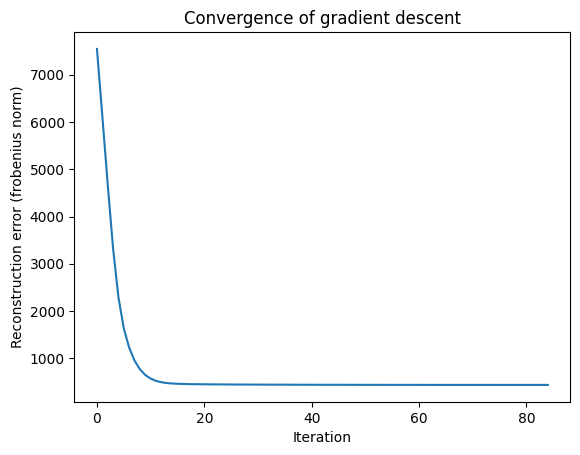

Reconstruction error of R: 436.0651089622514
Frob norm of predictions: 89.57014412081693
MSE (k=2): 0.7956769530718917
MAE (k=2): 0.6859023647993707


(array([[2.68914682, 2.8214771 ],
        [2.45146783, 2.51034822],
        [1.47146581, 1.48519817],
        ...,
        [1.99255525, 2.010974  ],
        [2.03243759, 2.12636339],
        [2.31892544, 2.34846297]]),
 array([[1.09768906, 0.67108539, 0.50972712, ..., 1.0449002 , 0.74011692,
         0.70883375],
        [0.66075384, 0.8897244 , 0.96085256, ..., 0.5491978 , 0.84556167,
         1.08668745]]))

In [135]:
# Now lets try with Grad Descent:
kwargs = {"max_iters": 5000, "lr": 0.00002, "patience": 5, "threshold": 0.1, "verbose":100, "plot":True}
main(R, k=2, method="gd",split=0.1, plot=False, method_kwargs=kwargs)

Number of ratings: 100836
Removing 10083 ratings...
Number of ratings removed: 10083
Step 0: Error: 440.54488125199646
Step 1: Error: 435.8530068737767
Step 2: Error: 435.85299281310233
U: (610, 1), M: (1, 9742)
Reconstruction error of R: 435.85299281310233
Frob norm of predictions: 89.57731037969968
MSE (k=1): 0.7958042779788782
MAE (k=1): 0.6859270688864961
Number of ratings: 100836
Removing 10083 ratings...
Number of ratings removed: 10083
Step 0: Error: 93867.67454793748
Step 1: Error: 1374.8902338040955
Step 2: Error: 943.0201800466706
Step 3: Error: 691.3336202236151
Step 4: Error: 536.8033812372393
Step 5: Error: 445.1384781579317
Step 6: Error: 391.5127054890199
Step 7: Error: 358.8791307701971
Step 8: Error: 338.65460889284265
Step 9: Error: 325.73818806131277
Step 10: Error: 317.32281904584585
Step 11: Error: 311.9436348334383
Step 12: Error: 308.7365067171464
Step 13: Error: 307.13012891001324
Step 14: Error: 306.6372170687897
Step 15: Error: 306.7709480300408
U: (610, 2), M

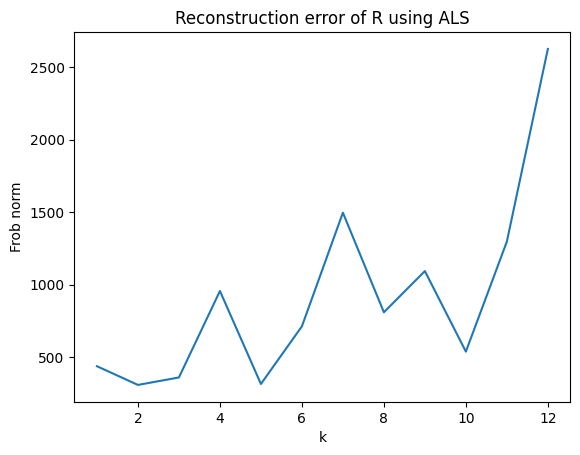

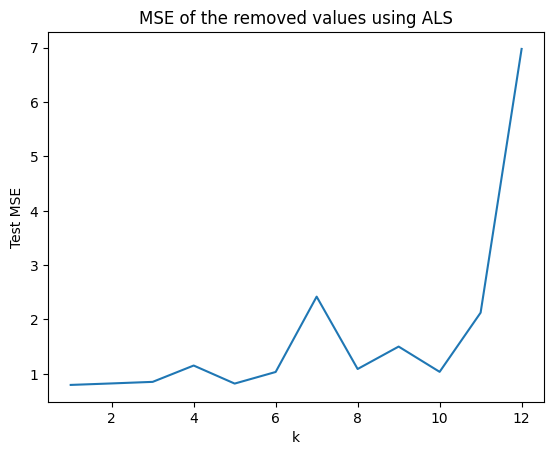

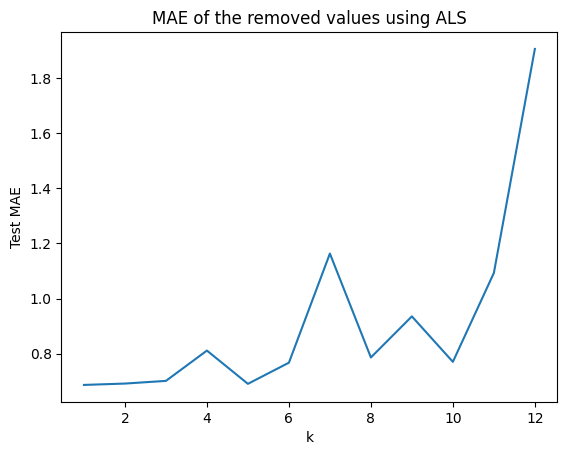

(array([[0.02165247, 0.12494595, 0.08690109, ..., 0.52794587, 0.1713818 ,
         0.        ],
        [0.003059  , 0.1125142 , 0.08357399, ..., 0.45772454, 0.14850567,
         0.        ],
        [0.        , 0.06064298, 0.07471733, ..., 0.2333409 , 0.06779759,
         0.        ],
        ...,
        [0.        , 0.14887394, 0.08974479, ..., 0.3533636 , 0.05189445,
         0.        ],
        [0.        , 0.09084196, 0.07930069, ..., 0.37089417, 0.11766087,
         0.        ],
        [0.        , 0.10087716, 0.10416702, ..., 0.42549504, 0.138775  ,
         0.        ]]),
 array([[2.67642882, 4.37467803, 4.45899562, ..., 2.62168523, 2.62168523,
         2.33604237],
        [0.48664212, 2.77053693, 0.        , ..., 1.18160005, 1.18160005,
         1.17637701],
        [7.40233066, 0.        , 4.90028137, ..., 1.31599743, 1.31599743,
         1.58364955],
        ...,
        [2.83951062, 1.40727691, 2.35256451, ..., 1.67066371, 1.67066371,
         1.68621139],
        [5.3

In [130]:
# And finally with ALS:
kwargs = {"max_iters": 100, "patience": 1, "threshold": 0.1, "plot":False}
main(R, k=list(range(1,13,1)), method="als",split=0.1, plot=True, method_kwargs=kwargs)

{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, '10': 11, '11': 12, '12': 13, '13': 14, '14': 15, '15': 16, '16': 17, '17': 18, '18': 19, '19': 20, '20': 21, '21': 22, '22': 23, '23': 24, '24': 25, '25': 26, '26': 27, '27': 28, '28': 29, '29': 30, '30': 31, '31': 32, '32': 34, '33': 36, '34': 38, '35': 39, '36': 40, '37': 41, '38': 42, '39': 43, '40': 44, '41': 45, '42': 46, '43': 47, '44': 48, '45': 49, '46': 50, '47': 52, '48': 53, '49': 54, '50': 55, '51': 57, '52': 58, '53': 60, '54': 61, '55': 62, '56': 63, '57': 64, '58': 65, '59': 66, '60': 68, '61': 69, '62': 70, '63': 71, '64': 72, '65': 73, '66': 74, '67': 75, '68': 76, '69': 77, '70': 78, '71': 79, '72': 80, '73': 81, '74': 82, '75': 83, '76': 85, '77': 86, '78': 87, '79': 88, '80': 89, '81': 92, '82': 93, '83': 94, '84': 95, '85': 96, '86': 97, '87': 99, '88': 100, '89': 101, '90': 102, '91': 103, '92': 104, '93': 105, '94': 106, '95': 107, '96': 108, '97': 110, '98': 111, '99': 112, '100':

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Movie: Movie: Toy Story (1995) (1)
Projection: [0.9521363  0.81610896]
Movie: Movie: GoldenEye (1995) (10)
Projection: [0.78210402 0.81543507]
Movie: Movie: Cutthroat Island (1995) (15)
Projection: [0.62270525 0.80722076]
Movie: Movie: Seven (a.k.a. Se7en) (1995) (47)
Projection: [0.97044946 0.82144499]
Movie: Movie: Lord of the Rings: The Fellowship of the Ring, The (2001) (4993)
Projection: [1.03042991 0.79714818]
Movie: Movie: Lord of the Rings: The Two Towers, The (2002) (5952)
Projection: [1.01949425 0.79885098]
Movie: Movie: Lord of the Rings: The Return of the King, The (2003) (7153)
Projection: [1.06682234 0.7941906 ]
Movie: Movie: Harry Potter and the Prisoner of Azkaban (2004) (8368)
Projection: [0.97319223 0.8101049 ]
Movie: Movie: Harry Potter and the Goblet of Fire (2005) (40815)
Projection: [0.9207383  0.81203876]
Movie: Movie: Harry Potter and the Order of the Phoenix (2007) (54001)
Projection: [0.94107968 0.82998158]
Movie: Movie: Harry Potter and the Half-Blood Prince 

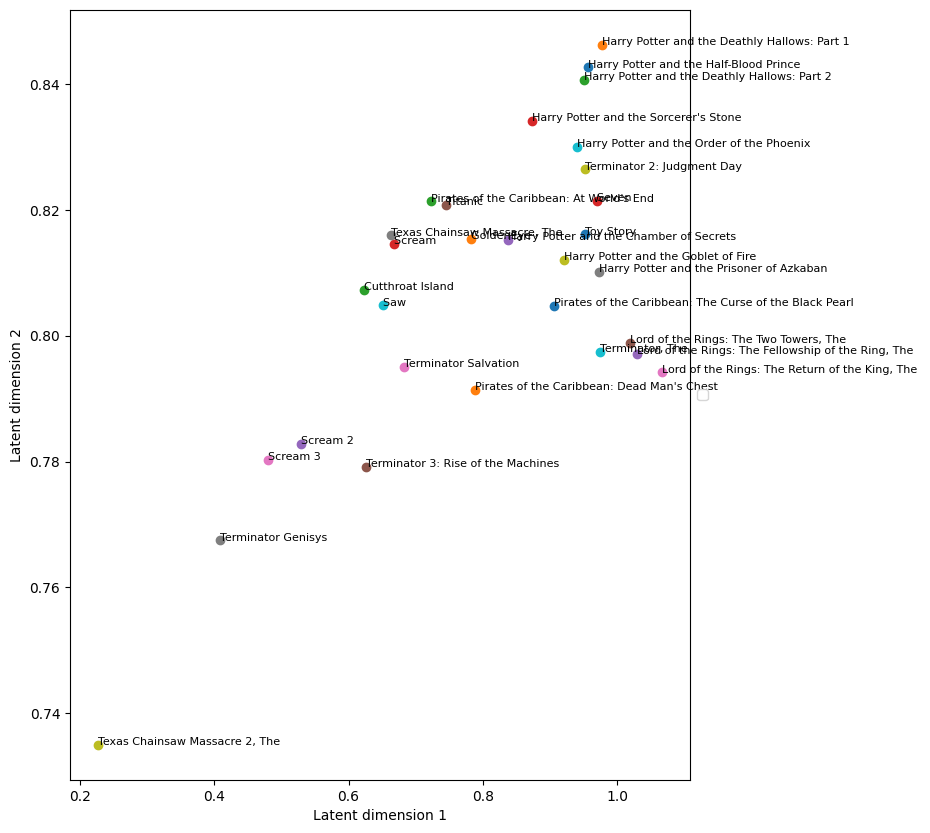

In [137]:

movie_id_to_sequential, sequential_movie_id_to_movieid, user_id_to_sequential_user_id, sequential_user_id_to_userid = get_id_conversions()
print(sequential_movie_id_to_movieid)
#{"max_iters": 2000, "lr": 0.00002, "patience": 10, "threshold": 0.001, "verbose":100, "plot":True}
U,M = main(R, k=2, method="gd",split=0.1, plot=False, method_kwargs = {"max_iters": 2000, "lr": 0.00002, "patience": 10, "threshold": 0.001, "verbose":100})
movie_ids = random.sample(range(0,R.shape[1]), 10)
selected_movie_ids = [1,10, 15, 47, 4993, 5952, 7153,8368, 40815, 54001, 
                      69844, 81834, 88125, 4896, 5816, 6537, 68791, 120799, 589, 1240, 6539, 45722, 53125,1407,
                      1717, 1721, 3273, 2459, 2460, 8957]
print(f"Seleceted {len(selected_movie_ids)} movies")
selected_seq_ids = [movie_id_to_sequential[str(i)] for i in selected_movie_ids]
fig,ax = plt.subplots()
ax.set_xlabel("Latent dimension 1")
ax.set_ylabel("Latent dimension 2")
fig.set_size_inches(10,10)
for seq_mov_id in selected_seq_ids:
    movie = MOVIES[seq_mov_id]
    as_k_vector = M[:,seq_mov_id]
    print(f"Movie: {movie}")
    print(f"Projection: {as_k_vector}")
    ax.scatter(as_k_vector[0], as_k_vector[1])
    title = movie.title.split("(")[0]
    ax.annotate(title, (as_k_vector[0], as_k_vector[1]), fontsize=8)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()